# CATARACT DETECTION USING TRANSFER LEARNING AND ENSEMBLE-STACKING MODEL

### Members- Sonu Besra, Harsh Tanwar, Harshit Nikela


### Overview-

One of the most common visual disorders is cataracts, which people suffer from as they get older. The creation of a cloud on the lens of our eyes is known as a cataract. Blurred vision, faded colors, and difficulty seeing in strong light are the main symptoms of this condition. These symptoms frequently result in difficulty doing a variety of tasks. As a result, preliminary cataract detection and prevention may help to minimize the rate of blindness. This project is aimed at classifying cataract disease using convolutional neural networks based on a publicly available image dataset. In this observation, four different convolutional neural network (CNN) meta-architectures, including InceptionV3, Resnet50 and VGG19, were applied by using the TensorFlow object detection framework. Moreover Created a stacking ensemble model using metaLearners to get the best results out of the three predictors.


### DATASET LINK:https://www.kaggle.com/datasets/andrewmvd/ocular-disease-recognition-odir5k

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
from keras.layers import Conv2D, GlobalAveragePooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D,BatchNormalization
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
from tensorflow.keras import Model

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
df = pd.read_csv(r"C:\Users\Sonu\Desktop\cataract\full_df.csv")
df.head(3)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg


In [4]:
def has_cataract(text):
    if "cataract" in text:
        return 1
    else:
        return 0

In [5]:
df["left_cataract"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
df["right_cataract"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_cataract(x))

In [6]:
left_cataract = df.loc[(df.C ==1) & (df.left_cataract == 1)]["Left-Fundus"].values
left_cataract[:15]

array(['0_left.jpg', '81_left.jpg', '103_left.jpg', '119_left.jpg',
       '254_left.jpg', '294_left.jpg', '330_left.jpg', '448_left.jpg',
       '465_left.jpg', '477_left.jpg', '553_left.jpg', '560_left.jpg',
       '594_left.jpg', '611_left.jpg', '625_left.jpg'], dtype=object)

In [7]:
right_cataract = df.loc[(df.C ==1) & (df.right_cataract == 1)]["Right-Fundus"].values
right_cataract[:15]

array(['24_right.jpg', '81_right.jpg', '112_right.jpg', '188_right.jpg',
       '218_right.jpg', '345_right.jpg', '354_right.jpg', '477_right.jpg',
       '553_right.jpg', '560_right.jpg', '625_right.jpg', '726_right.jpg',
       '769_right.jpg', '949_right.jpg', '955_right.jpg'], dtype=object)

In [8]:
print("Number of images in left cataract: {}".format(len(left_cataract)))
print("Number of images in right cataract: {}".format(len(right_cataract)))

Number of images in left cataract: 304
Number of images in right cataract: 290


In [9]:
left_normal = df.loc[(df.C ==0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(250,random_state=42).values
right_normal = df.loc[(df.C ==0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(250,random_state=42).values
right_normal[:15]

array(['2964_right.jpg', '680_right.jpg', '500_right.jpg',
       '2368_right.jpg', '2820_right.jpg', '2769_right.jpg',
       '2696_right.jpg', '2890_right.jpg', '940_right.jpg',
       '2553_right.jpg', '3371_right.jpg', '3042_right.jpg',
       '919_right.jpg', '3427_right.jpg', '379_right.jpg'], dtype=object)

In [10]:
cataract = np.concatenate((left_cataract,right_cataract),axis=0)
normal = np.concatenate((left_normal,right_normal),axis=0)
print(len(cataract),len(normal))

594 500


# Creating Dataset from Images

In [11]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
dataset_dir = "C:/Users/Sonu/Desktop/cataract/preprocessed"
image_size=224
labels = []
dataset = []
def create_dataset(image_category,label):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir,img)
        try:
            image = cv2.imread(image_path,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue
        
        dataset.append([np.array(image),np.array(label)])
    random.shuffle(dataset)
    return dataset

In [12]:
dataset = create_dataset(cataract,1)

100%|███████████████████████████████████████████████████████████████████████████████| 594/594 [00:03<00:00, 183.35it/s]


In [13]:
len(dataset)

588

In [14]:
dataset = create_dataset(normal,0)

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:03<00:00, 152.18it/s]


In [15]:
len(dataset)

1088

# Let's see some images

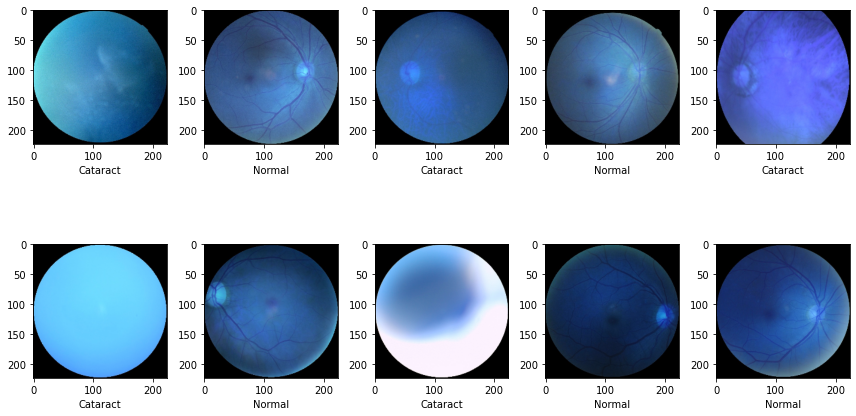

In [16]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    if category== 0:
        label = "Normal"
    else:
        label = "Cataract"
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout() 

# Dividing dataset into x(features) & y(target)

In [17]:
x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
y = np.array([i[1] for i in dataset])
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

In [18]:
x_train = x_train / 255.0
x_test = x_test / 255.0

# Creating Model -VGG19

In [61]:

vgg = VGG19(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))
for layer in vgg.layers:
    layer.trainable = False

In [62]:
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(1,activation="sigmoid"))
model.summary()
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_8 (Dense)             (None, 1)                 25089     
                                                                 
Total params: 20,049,473
Trainable params: 25,089
Non-trainable params: 20,024,384
_________________________________________________________________


# Image Augmentation

In [37]:

generator = ImageDataGenerator(
         rescale=1./255,
         rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images
generator.fit(x_train, seed=42)
checkpoint = ModelCheckpoint("vgg19.h5",monitor="val_accuracy",verbose=1,save_best_only=True,
                             save_weights_only=False,period=1)
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,verbose=1)

# Fitting

In [63]:
BATCH_SIZE=32
EPOCHS=8
history = model.fit(generator.flow(x_train,y_train,
                                   batch_size=BATCH_SIZE), 
                    epochs=EPOCHS,
                    steps_per_epoch=len(x_train)/BATCH_SIZE,
                    callbacks=[checkpoint,earlystop],
                    validation_data=(x_test, y_test))

Epoch 1/8
28/27 [==============================] - ETA: -3s - loss: 0.9120 - accuracy: 0.4885
Epoch 1: val_accuracy improved from -inf to 0.54587, saving model to vgg19.h5
27/27 [==============================] - 168s 6s/step - loss: 0.9120 - accuracy: 0.4885 - val_loss: 0.7350 - val_accuracy: 0.5459
Epoch 2/8
28/27 [==============================] - ETA: -3s - loss: 0.7117 - accuracy: 0.5000
Epoch 2: val_accuracy did not improve from 0.54587
27/27 [==============================] - 167s 6s/step - loss: 0.7117 - accuracy: 0.5000 - val_loss: 0.7509 - val_accuracy: 0.4541
Epoch 3/8
28/27 [==============================] - ETA: -3s - loss: 0.7060 - accuracy: 0.5218
Epoch 3: val_accuracy improved from 0.54587 to 0.55505, saving model to vgg19.h5
27/27 [==============================] - 157s 6s/step - loss: 0.7060 - accuracy: 0.5218 - val_loss: 0.6900 - val_accuracy: 0.5550
Epoch 4/8
28/27 [==============================] - ETA: -3s - loss: 0.7040 - accuracy: 0.5230
Epoch 4: val_accuracy di

# Loss, Accuracy

In [64]:
loss,accuracy = model.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

7/7 [==============================] - 31s 4s/step - loss: 0.7045 - accuracy: 0.4587
loss: 0.704498827457428
Accuracy: 0.4587155878543854


In [65]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
y_pred = (model.predict(x_test) > 0.5).astype("int32")

7/7 [==============================] - 31s 4s/step


In [66]:
accuracy_score(y_test,y_pred)

0.45871559633027525

In [67]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.45      0.84      0.58        99
           1       0.52      0.14      0.22       119

    accuracy                           0.46       218
   macro avg       0.48      0.49      0.40       218
weighted avg       0.48      0.46      0.39       218



# Trainning and Validation Accuracy,Loss

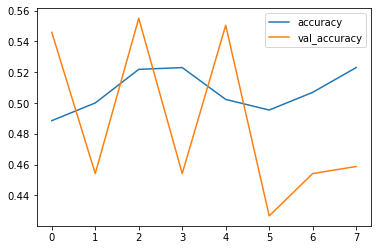

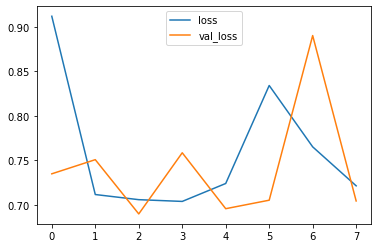

In [68]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

# RESNET 50

In [54]:

resnet = ResNet50(weights='imagenet',
                      input_shape= (224,224,3),
                      include_top= False) 

In [55]:
for layer in resnet.layers:
    layer.trainable = False

In [56]:
inputs = resnet.input
x = resnet.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation ='sigmoid')(x)
model2 = Model(inputs=inputs, outputs=outputs)
model2.compile(optimizer=Adam(lr=0.001),loss="binary_crossentropy",metrics=["accuracy"])

C:\Users\Sonu\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [57]:

callbacks = EarlyStopping(patience = 3, monitor='val_accuracy')
history2 = model2.fit(generator.flow(x_train,y_train,
                                   batch_size=BATCH_SIZE), 
                    epochs=EPOCHS,
                    steps_per_epoch=len(x_train)/BATCH_SIZE,
                    callbacks=[callbacks],
                    validation_data=(x_test, y_test))

Epoch 1/8
27/27 [==============================] - 67s 2s/step - loss: 0.8075 - accuracy: 0.4954 - val_loss: 0.7724 - val_accuracy: 0.5459
Epoch 2/8
27/27 [==============================] - 63s 2s/step - loss: 0.7423 - accuracy: 0.5437 - val_loss: 0.7916 - val_accuracy: 0.5459
Epoch 3/8
27/27 [==============================] - 69s 3s/step - loss: 0.7428 - accuracy: 0.5161 - val_loss: 0.6957 - val_accuracy: 0.5459
Epoch 4/8
27/27 [==============================] - 64s 2s/step - loss: 0.7301 - accuracy: 0.4954 - val_loss: 0.6882 - val_accuracy: 0.5459


# Loss, Accuracy score

In [69]:
loss,accuracy = model2.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

7/7 [==============================] - 14s 2s/step - loss: 0.6882 - accuracy: 0.5459
loss: 0.6881922483444214
Accuracy: 0.5458715558052063


# Trainning and Validation Accuracy,Loss

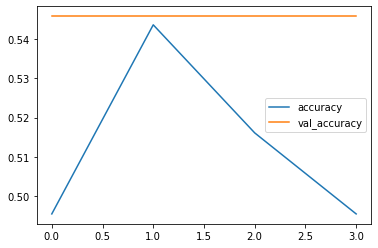

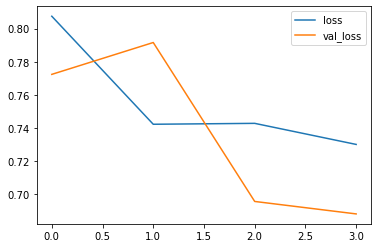

In [59]:
pd.DataFrame(history2.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history2.history)[['loss', 'val_loss']].plot()
plt.show()

# INCEPTION V3


In [39]:
BATCH_SIZE=32
EPOCHS=8

In [27]:
model3= InceptionV3(include_top=False, weights='imagenet',input_shape=(224,224,3), pooling='avg')

for layer in model3.layers:
    layer.trainable=False

In [49]:
    
model3=Sequential()
model3.add(InceptionV3(include_top=False, weights='imagenet',input_tensor=None, input_shape=(224,224,3), pooling='avg'))
model3.add(Dense(512,activation='relu'))
model3.add(BatchNormalization())
model3.add(Dense(1,activation='sigmoid'))
model3.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 dense_4 (Dense)             (None, 512)               1049088   
                                                                 
 batch_normalization_1224 (B  (None, 512)              2048      
 atchNormalization)                                              
                                                                 
 dense_5 (Dense)             (None, 1)                 513       
                                                                 
Total params: 22,854,433
Trainable params: 22,818,977
Non-trainable params: 35,456
_________________________________________________________________


In [52]:
reduce_learning_rate = ReduceLROnPlateau(monitor='loss',
                                         factor=0.1,
                                         patience=3,
                                         cooldown=2,
                                         min_lr=1e-10,
                                         verbose=1)

callbacks = [reduce_learning_rate]
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model3.compile(optimizer=optimizer,loss="binary_crossentropy",metrics=["accuracy"])
history3 = model3.fit(generator.flow(x_train,y_train,
                                   batch_size=BATCH_SIZE), 
                    epochs=EPOCHS,
                    steps_per_epoch=len(x_train)/BATCH_SIZE,
                    callbacks=[callbacks,],
                    validation_data=(x_test, y_test))

Epoch 1/8
27/27 [==============================] - 190s 6s/step - loss: 0.6380 - accuracy: 0.7540 - val_loss: 58.5192 - val_accuracy: 0.4908 - lr: 0.0010
Epoch 2/8
27/27 [==============================] - 172s 6s/step - loss: 0.3101 - accuracy: 0.8851 - val_loss: 1.0490 - val_accuracy: 0.6651 - lr: 0.0010
Epoch 3/8
27/27 [==============================] - 180s 7s/step - loss: 0.3236 - accuracy: 0.8724 - val_loss: 182.8654 - val_accuracy: 0.4541 - lr: 0.0010
Epoch 4/8
27/27 [==============================] - 172s 6s/step - loss: 0.2658 - accuracy: 0.8908 - val_loss: 1.3564 - val_accuracy: 0.7661 - lr: 0.0010
Epoch 5/8
27/27 [==============================] - 174s 6s/step - loss: 0.2727 - accuracy: 0.8931 - val_loss: 48003.6094 - val_accuracy: 0.4541 - lr: 0.0010
Epoch 6/8
27/27 [==============================] - 164s 6s/step - loss: 0.2726 - accuracy: 0.8966 - val_loss: 39421.8594 - val_accuracy: 0.4541 - lr: 0.0010
Epoch 7/8
27/27 [==============================] - 176s 7s/step - loss:

# Loss, Accuracy Score

In [70]:
loss,accuracy = model3.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

7/7 [==============================] - 6s 779ms/step - loss: 41.1170 - accuracy: 0.7523
loss: 41.117000579833984
Accuracy: 0.752293586730957


# Trainning and Validation Accuracy,Loss

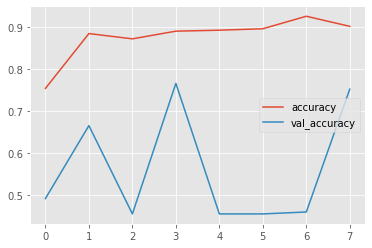

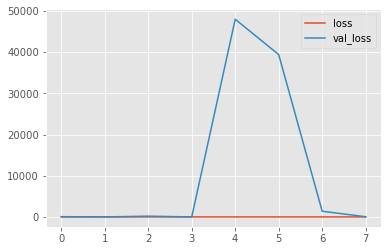

In [76]:
pd.DataFrame(history3.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history3.history)[['loss', 'val_loss']].plot()
plt.show()

# ENSEMBLE STACKING  

In [71]:
train= generator.flow(x_train, y_train, batch_size=32)
test= generator.flow(x_test, y_test, batch_size=32)

In [72]:
from deepstack.base import KerasMember  # For a generic (i.e., Non-Keras Model) check the class `Member`
from deepstack.ensemble import StackEnsemble

member1 = KerasMember(name="model1", keras_model=model, train_batches=train, val_batches=test)
member2 = KerasMember(name="model2", keras_model=model2, train_batches=train, val_batches=test)
member3 = KerasMember(name="model3", keras_model=model3, train_batches=train, val_batches=test)

C:\Users\Sonu\anaconda3\lib\site-packages\deepstack\base.py:147: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  return self.model.predict_generator(


7/7 [==============================] - 7s 945ms/step


In [73]:
from deepstack.ensemble import StackEnsemble
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier


stack = StackEnsemble()
estimators = [
    ('rf', RandomForestClassifier(verbose=0, n_estimators=100, max_depth=15, n_jobs=20, min_samples_split=30)),
    ('etr', ExtraTreesClassifier(verbose=0, n_estimators=100, max_depth=10, n_jobs=20, min_samples_split=20)),
    ('dtc',DecisionTreeClassifier(random_state=0, max_depth=3))
]
clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression()
)

stack.model = clf
stack.add_members([member1, member2,member3])
stack.fit()
stack.describe(metric=sklearn.metrics.accuracy_score)

Calling predict
model1 - accuracy_score: 0.2707
model2 - accuracy_score: 0.5663
model3 - accuracy_score: 0.5459
StackEnsemble accuracy_score: 0.6422


0.6422018348623854

# Prediction 